<a id='top-page'></a>
# <img src="../images/PCAfold-logo.svg" style="height:100px"> Demo for the QoI-aware encoder-decoder dimensionality reduction strategy

In this tutorial, we present the QoI-aware encoder-decoder dimensionality reduction strategy from the ``utitilities`` module.

Illustrative explanation of how the QoI-aware encoder-decoder works is presented in the figure below:

<img src="../images/tutorial-qoi-aware-encoder-decoder.png" style="height:400px">

### QoI-aware encoder-decoder

- [**Upload a combustion data set**](#data-set)
- [**Train the QoI-aware encoder-decoder**](#train)

***

**Should plots be saved?**

In [1]:
save_plots = True

***

We import the necessary modules:

In [2]:
from PCAfold import preprocess
from PCAfold import reduction
from PCAfold import analysis
from PCAfold import utilities
import numpy as np
%matplotlib inline

and we set some initial parameters:

In [3]:
save_filename = None

<a id='data-set'></a>
***

## Upload a combustion data set

[**↑ Go to the top**](#top-page)

A data set representing combustion of hydrogen in air generated from steady laminar flamelet model using [*Spitfire*](https://github.com/sandialabs/Spitfire) software [[1]](#references) is used as a demo data set. 

We begin by importing the data set composed of the original state space variables,
$\mathbf{X}$, and the corresponding source terms, $\mathbf{S_X}$:

In [4]:
X = np.genfromtxt('H2-air-state-space.csv', delimiter=',')[:,0:-2]
S_X = np.genfromtxt('H2-air-state-space-sources.csv', delimiter=',')[:,0:-2]
X_names = np.genfromtxt('H2-air-state-space-names.csv', delimiter='\n', dtype=str)[0:-2]

In [5]:
X_names

array(['T', 'H', 'H2', 'O', 'OH', 'H2O', 'O2', 'HO2', 'H2O2'], dtype='<U4')

In [6]:
(n_observations, n_variables) = np.shape(X)

<a id='train'></a>
***

## Train the QoI-aware encoder-decoder

[**↑ Go to the top**](#top-page)

We are going to generate 2D projections of the state-space:

In [7]:
n_components = 2

First, we are going to scale the state-space variables to a $\langle 0, 1 \rangle$ range. This is done to help the neural network training process.

We are also going to apply an adequate scaling to the source terms. This is done for consistency in reduced-order modeling (see: [**Handling source terms**](https://pcafold.readthedocs.io/en/latest/tutorials/demo-handling-source-terms.html)). The scaled source terms will serve as projection-dependent variables.

In [8]:
(input_data, centers, scales) = preprocess.center_scale(X, scaling='0to1')
projection_dependent_outputs = S_X / scales

We create a PCA-initialization of the encoder:

In [9]:
pca = reduction.PCA(X, n_components=n_components, scaling='auto')
encoder_weights_init = pca.A[:,0:n_components]

We visualize the initial projection:

In [10]:
X_projected = np.dot(input_data, encoder_weights_init)
S_X_projected = np.dot(projection_dependent_outputs, encoder_weights_init)

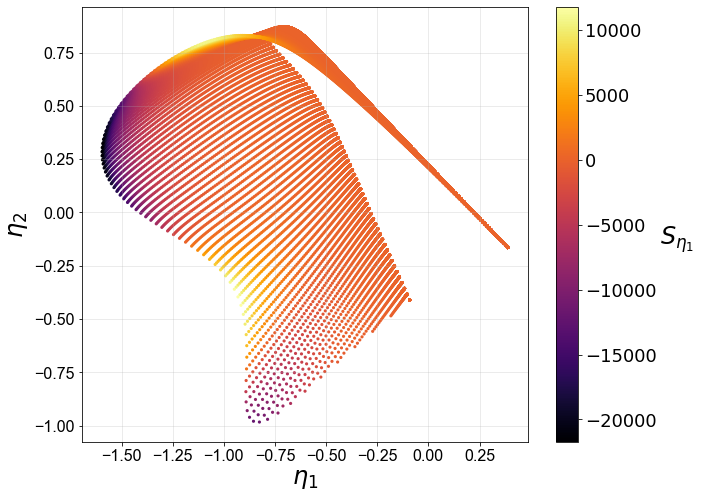

In [11]:
if save_plots==True: save_filename = '../images/tutorial-qoi-aware-encoder-decoder-initial-2D-projection.png'
plt = reduction.plot_2d_manifold(X_projected[:,0], 
                                 X_projected[:,1], 
                                 s=10,
                                 color=S_X_projected[:,0], 
                                 color_map='inferno',
                                 colorbar_label='$S_{\eta_1}$',
                                 x_label='$\eta_1$',
                                 y_label='$\eta_2$', 
                                 figure_size=(10,8), 
                                 save_filename=save_filename)

We select a couple of important state variables to be used as the projection-independent variables:

In [12]:
selected_state_variables = [0, 2, 4, 5, 6]

In [13]:
print(X_names[selected_state_variables])

['T' 'H2' 'OH' 'H2O' 'O2']


First, we fix the random seed for results reproducibility:

In [14]:
random_seed = 100

We set several important hyper-parameters:

In [15]:
activation_decoder = 'tanh'
decoder_interior_architecture = (6,9)
optimizer = 'Adam'
learning_rate = 0.001
loss = 'MSE'
batch_size = n_observations
validation_perc = 10

We are not going to hold initial weights constant, and we are going to allow the encoder to update weights at each epoch:

In [16]:
hold_initialization = None
hold_weights = None

We are going to train the model for 5000 epochs:

In [17]:
n_epochs = 5000

We instantiate an object of the `QoIAwareProjection` class with various parameters:

In [18]:
projection = utilities.QoIAwareProjection(input_data, 
                                          n_components=n_components, 
                                          projection_independent_outputs=input_data[:,selected_state_variables],
                                          projection_dependent_outputs=projection_dependent_outputs,
                                          activation_decoder=activation_decoder,
                                          decoder_interior_architecture=decoder_interior_architecture,
                                          encoder_weights_init=encoder_weights_init,
                                          decoder_weights_init=None,
                                          hold_initialization=hold_initialization,
                                          hold_weights=hold_weights,
                                          transformed_projection_dependent_outputs='signed-square-root',
                                          loss=loss,
                                          optimizer=optimizer,
                                          batch_size=batch_size,
                                          n_epochs=n_epochs,
                                          learning_rate=learning_rate,
                                          validation_perc=validation_perc,
                                          random_seed=random_seed,
                                          verbose=True)

Before we begin neural network training, we can print the summary of the current Keras model:

In [19]:
projection.summary()

QoI-aware encoder-decoder model summary...

(Model has not been trained yet)


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Projection dimensionality:

	- 2D projection

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Encoder-decoder architecture:

	9-2-6-9-9

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Activation functions:

	(9)--linear--(2)--tanh--(6)--tanh--(9)--tanh--(9)

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Variables at the decoder output:

	- 5 projection independent variables
	- 2 projection dependent variables
	- 2 transformed projection dependent variables using signed-square-root

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

We train the current Keras model:

In [20]:
projection.train()

  0%|          | 0/5000 [00:00<?, ?it/s]

Starting model training...


Decoder outputs are scaled to a -1 to 1 range.
Using 10% of input data as validation data. Model will be trained on 90% of input data.



100%|██████████| 5000/5000 [10:23<00:00,  8.02it/s]

Time it took: 10.4 minutes.



We can visualize the MSE loss computed on training and validation data during training:

<module 'matplotlib.pyplot' from '/Users/kamilazdybal/anaconda3/envs/spitfire/lib/python3.7/site-packages/matplotlib/pyplot.py'>

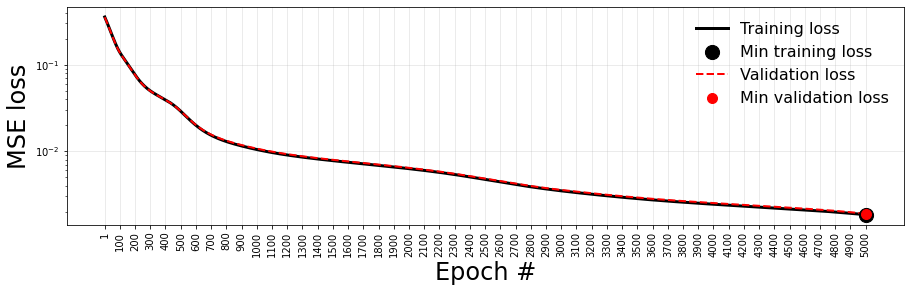

In [21]:
if save_plots==True: save_filename = '../images/tutorial-qoi-aware-encoder-decoder-losses.png'
projection.plot_losses(markevery=100,
                       figure_size=(15, 4),
                       save_filename=save_filename)

After training, additional information is available in the model summary:

In [22]:
projection.summary()

QoI-aware encoder-decoder model summary...

(Model has been trained)


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Projection dimensionality:

	- 2D projection

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Encoder-decoder architecture:

	9-2-6-9-9

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Activation functions:

	(9)--linear--(2)--tanh--(6)--tanh--(9)--tanh--(9)

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Variables at the decoder output:

	- 5 projection independent variables
	- 2 projection dependent variables
	- 2 transformed projection dependent variables using signed-square-root

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

We extract the best lower-dimensional basis that corresponds to the epoch with the smallest training loss:

In [23]:
basis = projection.get_best_basis(method='min-validation-loss')

Minimum validation loss:		0.0019012088887393475
Minimum validation loss at epoch:	5000


We project the original dataset onto that basis:

In [24]:
X_projected = np.dot(input_data, basis)
S_X_projected = np.dot(projection_dependent_outputs, basis)

We visualize the current manifold topology:

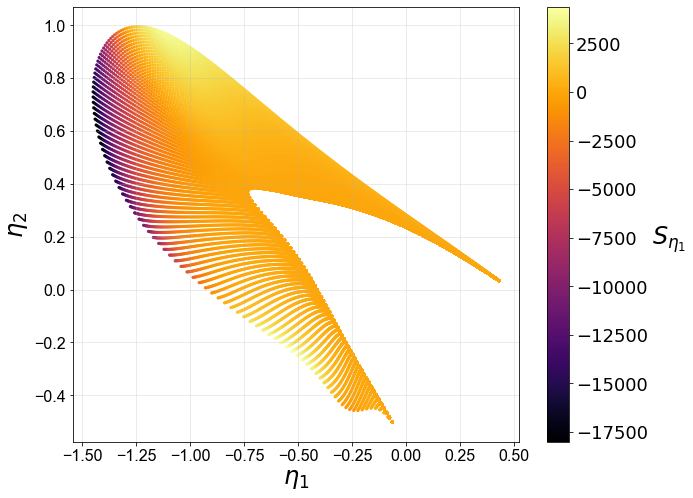

In [25]:
if save_plots==True: save_filename = '../images/tutorial-qoi-aware-encoder-decoder-2D-projection.png'
plt = reduction.plot_2d_manifold(X_projected[:,0], 
                                 X_projected[:,1], 
                                 s=10,
                                 color=S_X_projected[:,0], 
                                 color_map='inferno',
                                 colorbar_label='$S_{\eta_1}$',
                                 x_label='$\eta_1$',
                                 y_label='$\eta_2$', 
                                 figure_size=(10,8), 
                                 save_filename=save_filename)

<a id='references'></a>
***

## References

[**↑ Go to the top**](#top-page)
<a id='references'></a>

> [[1]](#data-set) [M. A. Hansen, *Spitfire*, 2020](https://github.com/sandialabs/Spitfire)
> 
> [[2]](#data-set) E.R. Hawkes, R. Sankaran, J.C. Sutherland, J.H. Chen, *Scalar mixing in direct numerical simulations of temporally evolving plane jet flames with skeletal CO/H2 kinetics*, Proceedings of the combustion institute 31 (1) (2007) 1633–1640
>
> [[3]](#theory) K. Zdybał, A. Parente, J. C. Sutherland, *Improving reduced-order models through nonlinear decoding of projection-dependent model outputs*, 2023.

***